In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
np.random.seed(2)

# Bayesian Attribution

### Distinguishing between "because of" and "in the presences of'

## Problem Statement:

We want to incentivize members to do a certain action (e.g, complete a telehealth session).
We offer a range of incentives and would like to assess the effectiveness of each program.

Some members will convert without any incentive (spontaneous of baseline conversion).
Many members will be offered more than one incentive.

## Four Types of Incentives or Promoting Factors:

#### 1. Direct Incentives - Things we do intentionally

* The member is offered cash to convert. 
* We send them a reminder email. 
* We put the link at the top of their homepage.

#### 2. Contributing Factors - Things we know about but have no control over.

* The member is a parent of young children. 
* The member had surgery within the last year. 
* The member has met their deductible for the year.

#### 3. Interaction Factors - Combinations of incentives and factors that work well together.

* The member is a mother AND received a Mother's Day promotion
* The member uses an Android phone AND received promotional message X.

#### 4. Baseline Factors - Everything Else

* The member already knew about our services and decided to use it on their own
* All other factors that we don't know about.
* All factors that we do know about but elected not to include in our model

## Challenges:

### Getting a 'clean' read.

Ideally, we would have one group that received Incentive A and nothing else, and another that received Incentive B and nothing else, etc.
Realistically, most members will receive multple direct incentives and have multiple contributing factors outside of our control.

There are no members who aren't subject to spontaneous conversion, so we have no direct way to do a WITH/WITHOUT comparison on baseline.

## Procedure

Each incentive or factor has a fixed probability $P_i$ of causing conversion.

Each member has a vector with a $0$ for each incentive/factor they do not have and a $1$ for those they do have.

For convenience, we also include a 'NULL' value of $1$ for every member to account for the baseline that is true for everyone.

We mark the outcome as $0$ if they did not complete the desired outcome and $1$ if they did.

For example:
* member $1$ has factors A,B and E and had a positive outcome
* member $2$ has factors B, C and D and did not convert
* member $3$ has facotres A and C and did convert

In [2]:
df = pd.DataFrame(dtype=int, columns = ['null','A','B','C','D','E','outcome'])
df.loc['Member_1'] = (1,1,1,0,0,1,1)
df.loc['Member_2'] = (1,0,1,1,1,0,0)
df.loc['Member_3'] = (1,1,0,1,0,0,1)
df=df.astype(int)
df

,null,A,B,C,D,E,outcome
Member_1,1,1,1,0,0,1,1
Member_2,1,0,1,1,1,0,0
Member_3,1,1,0,1,0,0,1


## Additive Probability

Unfortunately, probabilites do not add simply. 
If a member is offered $4$ incentives that are each known to be $30\%$ effective, they don't have a $120\%$ probability of conversion.

Probabilities add "in the negative". That is, you add up all the things that don't happen and what is left over is what does happen.

### The probability that a member will convert when presented with several incentives is one minus the probability that they will *not* convert due to all of the incentives.

If $P_i$ is the probability of conversion due to factor $i$, then $(1-P_i)$ is the probability of not converting due to that factor.

$P_{total}$ is the probability of converting due to a combination of factors

$$P_{total} = 1 -\underbrace {(1-P_{null})}_\text {Doesn't spontaneously convert}\cdot \underbrace {(1-P_A)}_\text {Doesn't convert because of A}\cdot \underbrace {(1-P_B)}_\text {Doesn't convert because of B}\cdot \underbrace {(1-P_C)}_\text {Doesn't conver becaues of C}...$$

Therefore, the conversion rate if offered $4$ incentives at $30\%$ each is:

$$P_{total} = 1 - (1-.3)\cdot (1-.3)\cdot (1-.3)\cdot (1-.3)$$

$$P_{total} = 1 - (.7)\cdot (.7)\cdot (.7)\cdot (.7) = 76\%$$


To account for factors that the member does/does not have, we raise each factor to $0$ or $1$ indicating presence or absence of a factor.


$$\large P_{total} = 1 - (1-P_A)^{X_A}\cdot (1-P_B)^{X_B}\cdot (1-P_C)^{X_C}\cdot (1-P_D)^{X_D}\cdot(1-P_E)^{X_E}...$$


$$\large P_{total} = 1 - \prod_{i=A,B,C,D,E...}(1-P_i)^{X_i}$$

This may be simplified by using the logarithm rule and representing $[X_A, X_B, X_C]$ as $\vec X$ (and the same for $\vec P$

$$\large P_{total} = 1-e^{\vec X \cdot {ln(1-\vec P)}}$$



### This gives us the ability to distinguish between conversion *because of* a factor vs. conversion *with a factor* 

$$\large \underbrace {P_\text{(A and other factors)}}_\text {conversion with A and other factors} = 1 - \underbrace {(1-P_A)}_\text {due to A alone}\cdot \underbrace {\prod_{i\ne A}(1-P_i)^{X_i}}_\text {conversion due to all factors execpt A}$$

$$ $$

Rearrange to isolate $P_A$:

$$\large \underbrace {P_{A}}_\text{because of A} = 1-\frac{1-P_\text{(with A)}}{1-P_\text{(without A)}}$$

#### Note: For a first approximation, we assume that $X_i$ is independent of $A$. That is to say, the presence of factors *B,C,D,E, etc* are distributed the same for people with factor *A* and those without it.  (We will correct for this later)

$\large P_\text{(with A)}$ and $\large P_\text{(without A)}$ can be read directly from our results table, e.g:
```SQL

SELECT
    A,
    AVERAGE(OUTCOME) 
FROM results
GROUP BY A
```

## The Bayesian Part

$$\large P_{A} = 1-\frac{1-P_\text{(A=1)}}{1-P_\text{(A=0)}}$$

However, as we learned last time, $P$ is not just a single value. Estimates of $\hat P$ are distributed over a range of values in the vicinity of true $P$.

So we replace $\hat P$ (a point estimate) with $\beta$, a distrbution of values and take the Expectation Value.

$$\large P_{A} = 1- \frac{1-E( {\beta (a_{with}, b_{with})})}{1- E(\beta (a_{without}, b_{without}))}$$

The values $a$ and $b$ correspond to number of successes and number of failures and can be read directly from the results table:

```SQL

SELECT
    A,
    OUTCOME,
    COUNT(*)
FROM
    RESULTS
GROUP BY A, OUTCOME
```


## Procedure:

### Step 1: First Approximation for each identifiable cause:

For each factor (or incentive):
* Use the GROUP BY logic to obtain counts of success and failure for WITH and WITHOUT groupings.
* Use the formula above to calculate a point estimate $\hat P$ for BECAUSE
* Use the number of observations ($N$) from the WITH group to estimate:
$$\large a_{because} = \hat P_A \cdot N_{A}$$
$$\large b_{because} = (1-\hat P_A) \cdot N_{A}$$

We now have a distribution estimate for each factor: 
$$\large P_i = \beta \left (N_i\cdot \left (1- \frac{1-E[{\beta (a_{with}, b_{with})}]}{1- E[\beta (a_{without}, b_{without})]}\right ), N_i \cdot \left (\frac{1-E[ {\beta (a_{with}, b_{with})}]}{1- E[\beta (a_{without}, b_{without})]}\right )\right )$$

### Step 2:

Tally up the total effect of all of these *known* causes:

$$\text {Conversions due to known incentives} = \large \sum_i P = \sum_i 1- e^{\vec X_i \cdot ln(1-\vec P_i)}$$

Generally, this value will be different than the total number of conversions observed.
The difference is the number of *spontaneous* conversions, or (e.g, conversions due to causes that cannot be independently assessed)

We again apply the WITH/WITHOUT/BECAUSE equation:

$$\Large P_{spontaneous} = 1 - \frac {1- P_\text {all causes}}{1- P_\text{ known causes}}$$

### Step 3: (Optional)

We now know every incentive that every member was offered *and* the estimates of their effectiveness.

Therefore, we don't need to assume (as we did previously) identical distribtuion of incentives when doing the WITH/WITHOUT analysis.

We can repeate Step 1 using estimates of $P$ for all factors rather than coarse GROUP BY statements.


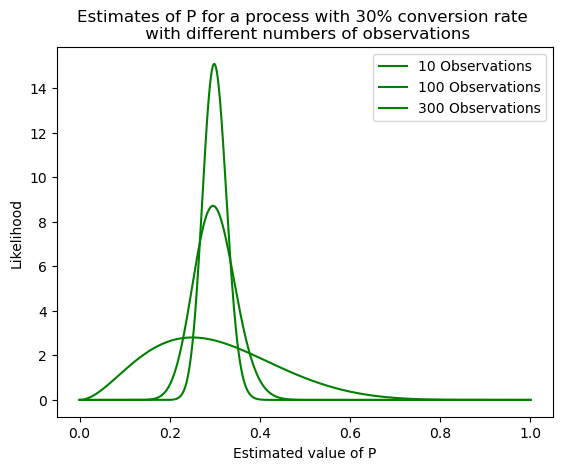

In [3]:
x = np.linspace(0,1,1000)
[plt.plot(x, beta(3*i,7*i).pdf(x), color='green', label=f'{i*10} Observations' ) for i in (1,10,30)]
plt.title('Estimates of P for a process with 30% conversion rate \n with different numbers of observations')
plt.legend()
plt.xlabel('Estimated value of P')
plt.ylabel('Likelihood');

# Let's look at some experimental data.

### 160,000 Members received between 0 and 5 Incentives (plus the null incentive)

Since I created this data myself, I happen to know the *true* effectiveness of all the incentives.
* Spontanous conversion = 5%
* Incentives 1-5: (11%, 18%, 8%, 15%, 21%)

(Naturally we wouldn't know this in the real world)


In [138]:
df = pd.read_csv('results_data2.csv')
df

,null,Incentive_1,Incentive_2,Incentive_3,Incentive_4,Incentive_5,outcome
0,1,0,0,0,1,1,0
1,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0
3,1,0,0,1,1,1,0
4,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...
63995,1,0,1,0,0,1,0
63996,1,0,0,0,1,1,0
63997,1,0,0,0,1,0,0
63998,1,0,0,0,1,1,1


In [139]:
# Note that some incentives occur far more often than others and some are more effective than others
df.describe().loc['mean']

null           1.000000
Incentive_1    0.031250
Incentive_2    0.118156
Incentive_3    0.269578
Incentive_4    0.479766
Incentive_5    0.751609
outcome        0.293328
Name: mean, dtype: float64

In [140]:
## The "true" effectiveness of the incentives.
## In application, these values are not known in advance.

true = np.array([0.05, 0.11, 0.18, 0.08, 0.15, 0.21])

In [141]:
df.groupby(['Incentive_1','outcome']).sum()['null']

Incentive_1  outcome
0            0          43946
             1          18054
1            0           1281
             1            719
Name: null, dtype: int64

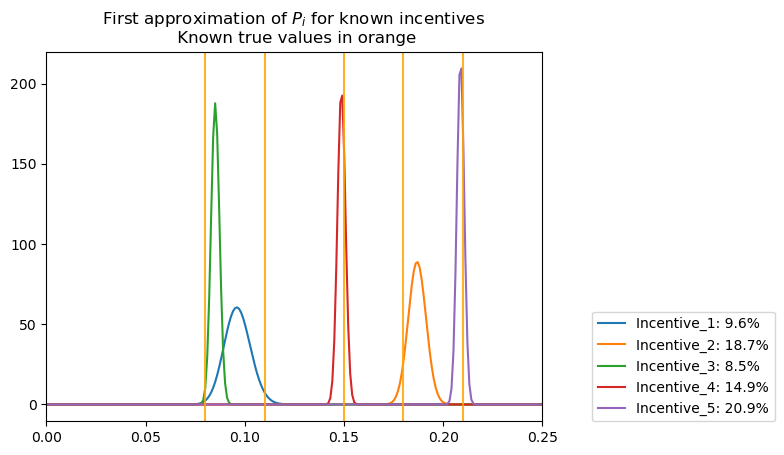

In [142]:
estimated_probabilities = {}
for i in (1,2,3,4,5):
    (without_b,
     without_a,
     with_b,
     with_a) = df.groupby([f'Incentive_{i}','outcome']).sum()['null'].values
    with_=beta(with_a, with_b)
    without_=beta(without_a, without_b)
    P = 1-(1-with_.mean())/(1-without_.mean())
    N = df[f'Incentive_{i}'].sum()
    because_a = P*N
    because_b = (1-P)*N
    because = beta(because_a,because_b)
    estimated_probabilities[i] = because.mean()

    plt.plot(x, because.pdf(x), label = f'Incentive_{i}: {100*because.mean():.1f}%')
plt.xlim([0,.25])
plt.legend(loc=[1.1,0])
[plt.axvline(i, color='orange', alpha=.85) for i in true[1:]]
plt.title('First approximation of $P_i$ for known incentives \n Known true values in orange');

In [143]:
estimated_probabilities, true[1:]

({1: 0.09636827014972915,
  2: 0.18694216861806934,
  3: 0.08516016432188023,
  4: 0.1487649272371211,
  5: 0.20878647090111013},
 array([0.11, 0.18, 0.08, 0.15, 0.21]))

## Use these values to tally how many conversions are expected due to these *known* causes

In [144]:
expected_conversions_from_known_causes = (1-np.exp(np.log(1-df.iloc[:,1:-1]*
                                                          estimated_probabilities.values()).sum(axis=1))).sum()

expected_conversions_from_known_causes

16268.915133218085

## Compare to actual conversions from all causes (including spontaneous)

In [145]:
print(f'''Actual conversions: {df['outcome'].sum()} 
Expected conversions: {expected_conversions_from_known_causes}''')

Actual conversions: 18773 
Expected conversions: 16268.915133218085


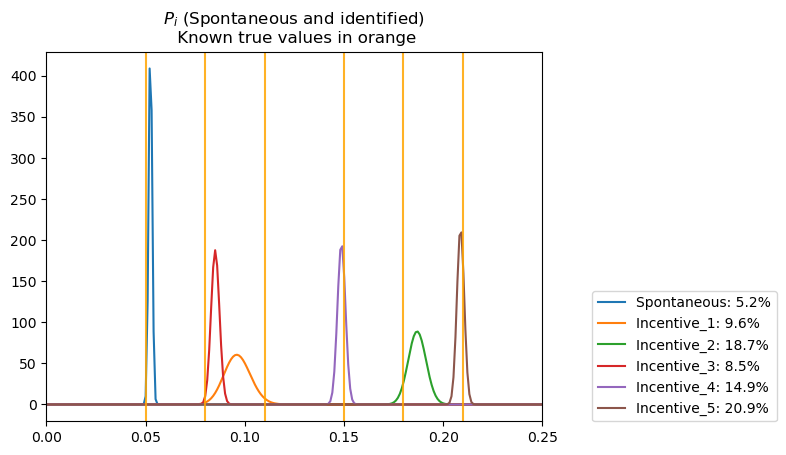

In [146]:
spontaneous = 1 - (1-beta(df['outcome'].sum(), len(df)-df['outcome'].sum()).mean())/(1-beta(expected_conversions_from_known_causes.sum(),len(df)-expected_conversions_from_known_causes.sum()).mean())
spontaneous= beta(len(df)*spontaneous, len(df)*(1-spontaneous))
plt.plot(x, spontaneous.pdf(x), label=f'Spontaneous: {100*spontaneous.mean():.1f}%');
spontaneous.interval(.9)

for i in (1,2,3,4,5):
    (without_b,
     without_a,
     with_b,
     with_a) = df.groupby([f'Incentive_{i}','outcome']).sum()['null'].values
    with_=beta(with_a, with_b)
    without_=beta(without_a, without_b)
    P = 1-(1-with_.mean())/(1-without_.mean())
    N = df[f'Incentive_{i}'].sum()
    because_a = P*N
    because_b = (1-P)*N
    because = beta(because_a,because_b)
    

    plt.plot(x, because.pdf(x), label = f'Incentive_{i}: {100*because.mean():.1f}%')
plt.xlim([0,.25])
plt.legend(loc=[1.1,0])
[plt.axvline(i, color='orange', alpha=.85) for i in true]
plt.title('$P_i$ (Spontaneous and identified)\n Known true values in orange');

In [147]:
estimated_probabilities[0] = spontaneous.mean()
estimated = np.array([estimated_probabilities[i] for i in range(len(estimated_probabilities))])
estimated

array([0.05246235, 0.09636827, 0.18694217, 0.08516016, 0.14876493,
       0.20878647])

In [27]:
f=1
(1-np.exp(np.log(1-(df.iloc[:,:-1]*estimated).drop(f'Incentive_{f}',axis=1)).sum(axis=1))).sum()

11068.703015430237

with 391 565 0.4089958158995816
0.09646735490921976 0.0960732794082747 0.09
with 1620 2226 0.42121684867394693
0.12603588938408694 0.12738830912291432 0.13
with 3692 4839 0.43277458680107844
0.1696473788444678 0.17098627197494298 0.17
with 6489 8761 0.42550819672131146
0.20538912428422518 0.20491891852030042 0.21
with 9458 14420 0.3960968255297764
0.23966802308988422 0.2396293094799955 0.25


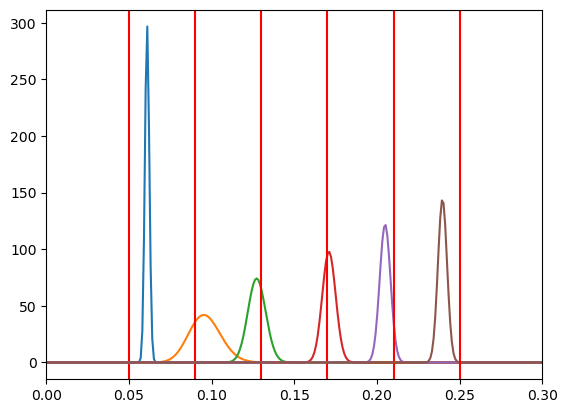

In [28]:
plt.plot(x, spontaneous.pdf(x), label=f'Spontaneous {spontaneous.mean()}')
plt.axvline(true[0], color='red')

for i in (1,2,3,4,5):
    subset = df[df[f'Incentive_{i}']==1]
    
    with_ = beta(subset['outcome'].sum(), (1-subset['outcome']).sum())
    print('with',subset['outcome'].sum(), (1-subset['outcome']).sum(), with_.mean())
    other_factors = (1-subset.iloc[:,:-1]*estimated).drop(f'Incentive_{i}',axis=1)
#     print(other_factors)
    predicted = (1-np.exp(np.log(other_factors).sum(axis=1))).sum()
    
    without_ = beta(predicted, len(subset)-predicted)
#     print('predicted',predicted,len(subset)-predicted, without_.mean())
    p = 1-(1-with_.mean())/(1-without_.mean())
#     print('because',p, true[i], len(subset))
#     print('a ',p*len(subset), ' b ',(1-p)*len(subset))
    new_estimate = beta(p*len(subset),(1-p)*len(subset))
    plt.plot(x, new_estimate.pdf(x))
    print(estimated_probabilities[i],new_estimate.mean(), true[i])
    plt.axvline(true[i], color='red')
#     plt.axvline(estimated_probabilities[i])
plt.xlim([0,.3]);

In [29]:
.6/.65

0.923076923076923

In [30]:
second_estimate = 1-np.exp((np.log(1-df.iloc[:,:-1]*estimated)).sum(axis=1))
second_estimate

133428    0.528906
21058     0.253823
153630    0.286012
158858    0.286012
101206    0.432658
            ...   
9791      0.060953
40607     0.347868
43935     0.407139
27912     0.458501
20810     0.528906
Length: 32000, dtype: float64

In [ ]:
estimated_probabilities = {}
plt.plot(x, spontaneous.pdf(x), label=f'Spontaneous {spontaneous.mean()} ')
for i in (1,2,3,4,5):
    without_b = (1-second_estimate[df[f'Incentive_{i}']==0]).sum()
    without_a = second_estimate[df[f'Incentive_{i}']==0].sum()
    with_b = (1-second_estimate[df[f'Incentive_{i}']==1]).sum()
    with_a = second_estimate[df[f'Incentive_{i}']==1].sum()
    with_=beta(with_a, with_b)
    without_=beta(without_a, without_b)
    P = 1-(1-with_.mean())/(1-without_.mean())
    N = df[f'Incentive_{i}'].sum()
    because_a = P*N
    because_b = (1-P)*N
    because = beta(because_a,because_b)
    estimated_probabilities[i] = because.mean()

    plt.plot(x, because.pdf(x), label = f'Incentive_{i}: {because.mean()}')
plt.xlim([0,.4])
plt.legend(loc=[1.1,0])
[plt.axvline(i, color='orange', alpha=.5) for i in true];

In [ ]:
def get_a(dist):
    return ((dist.mean()*(1-dist.mean())/(dist.var())-1)*dist.mean())
def get_b(dist):
    return ((dist.mean()*(1-dist.mean()))/(dist.var())-1)*(1-dist.mean())

In [ ]:
get_a(without_), get_b(without_), get_a(with_), get_b(with_)

In [ ]:
1-(1-with_.mean())/(1-without_.mean())

In [ ]:
with_.mean(), without_.mean()

In [ ]:
1-(1-with_.ppf([.19/2,.5,1-.19/2]))/(1-without_.ppf([.19/2, .5, 1-.19/2]))

In [ ]:
A = 1-(1-with_.mean())/(1-without_.mean())
A

In [ ]:
plt.plot(x,beta(A*30, (1-A)*30).pdf(x))
[plt.axvline(i) for i in 1-(1-with_.ppf([.19/2,.5,1-.19/2]))/(1-without_.ppf([.19/2, .5, 1-.19/2]))]
plt.axvline(A, color='red')

In [ ]:
plt.plot(x,[(with_.interval(i)[1]-with_.interval(i)[0]) for i in x])
plt.ylabel('Credible Interval')
plt.xlabel('credibility')
plt.axhline(with_.var()**.5)
plt.axhline(with_.var(), color='red')
# plt.xlim([.3,.4])
# plt.ylim([0,.2])
plt.axvline(1/np.e)

In [ ]:
1/np.exp(1)

In [ ]:
.5-1/(2*np.e)

In [ ]:
.5+1/(2*np.e)

In [ ]:
(with_.ppf(.5+1/(2*np.e))- with_.ppf(.5-1/(2*np.e)))**2

In [ ]:
with_.var()

In [ ]:
lo = .5-1/(2*np.e)
hi = .5+1/(2*np.e)
lo, hi

In [ ]:
with_.ppf(hi),with_.ppf(lo)

In [ ]:
plt.plot(x,with_.pdf(x))
[plt.axvline(with_.ppf(i)) for i in (hi,lo)]

In [ ]:
with_.interval(1/np.e)

In [ ]:
1-(1-with_.mean())/(1-without_.mean())

In [ ]:
8/22

In [ ]:
10/20

In [ ]:
1-(1-8/22)*(.9)

In [ ]:
without_.mean()